 Which players performed best on their new teams?
Throughout the season, players frequently change teams as management seeks to make roster adjustments to improve both short-term and long-term success. Which players achieved the highest efficiency with their new respective teams across the league in the 2023-24 NBA season?

In [1]:
import re
from io import BytesIO

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup
from PIL import Image

In [2]:
def get_image_from_url(url):
    """
    Fetches an image from the given URL and returns it as an OffsetImage.

    Parameters:
    url (str): The URL of the image to fetch.

    Returns:
    OffsetImage: The image fetched from the URL, scaled to a 
    zoom level of 0.2.
    """
    response = rq.get(url)
    img = Image.open(BytesIO(response.content))
    return OffsetImage(img, zoom=0.2)

def calculate_limits(df, col, adjustment_percentage):
    """
    Calculates the adjusted minimum and maximum limits for a given
    column in a DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    col (str): The column name for which to calculate the limits.
    adjustment_percentage (float): The percentage by which to adjust
    the range.

    Returns:
    tuple: A tuple containing the adjusted minimum and maximum limits.
    """
    min, max = df[col].min(), df[col].max()
    range = max - min
    min_limit = min - adjustment_percentage * range
    max_limit = max + adjustment_percentage * range
    return min_limit, max_limit

In [3]:
# Fetch all current NBA players, determine who has changed teams this
# season and put them in a list.

url = 'https://www.basketball-reference.com/leagues/NBA_2024_advanced.html'
players = pd.read_html(url)[0]
traded_players = players[players['Tm'] == 'TOT'].copy()
player_list = traded_players['Player'].tolist()

In [4]:
# Get all traded player entries, process and clean statistics of
# current team and sort & filter by data to be shown in graph.

traded_players_all_teams = players[players['Player'].isin(player_list)].copy()
traded_players_new_team = traded_players_all_teams.groupby('Player').tail(1).copy()
traded_players_new_team.loc[:, 'BPM'] = traded_players_new_team['BPM'].apply(
    lambda x: float(x)
)
traded_players_new_team.loc[:, 'PER'] = traded_players_new_team['PER'].apply(
    lambda x: float(x)
)
traded_players_new_team.loc[:, 'MP'] = traded_players_new_team['MP'].apply(
    lambda x: int(x)
)
traded_players_new_team.loc[:, 'G'] = traded_players_new_team['G'].apply(
    lambda x: int(x)
)
traded_players_new_team.insert(
    traded_players_new_team.columns.get_loc('PER'), 'MPG', 
    (traded_players_new_team['MP'] / traded_players_new_team['G'])
    .astype(float).round(1)
)
traded_players_sorted = traded_players_new_team.sort_values(
    by=['PER'], ascending=[False]
)
traded_players_sorted_filtered = traded_players_sorted[
    traded_players_sorted['MP'] >= 100
]

In [5]:
# Determine positive and negative Top 5 and create list to be
# used for fetching player's picture.

top_5 = traded_players_sorted_filtered.head(5)
bottom_5 = traded_players_sorted_filtered.tail(5)
both_ends = pd.concat([top_5, bottom_5])

In [6]:
# Fetch all players from original URL and create a dictionary
# with the player's name and his base abbreviation used in
# the player's picture URL.

html_content = rq.get(url).text
soup = BeautifulSoup(html_content, 'html.parser')
players_content = soup.find_all(attrs={'class': 'full_table'})
player_dictionary = {}
for element in players_content:
    player_name = element.find('a').contents[0]
    player_link = element.find('a')['href']
    player_link_elements = re.split('[/.]', player_link)
    player_link_base = '/'.join(player_link_elements[3:4])
    player_dictionary[player_name] = player_link_base
base_url = (
    'https://www.basketball-reference.com/req/202106291/images/headshots/{}.jpg'
)

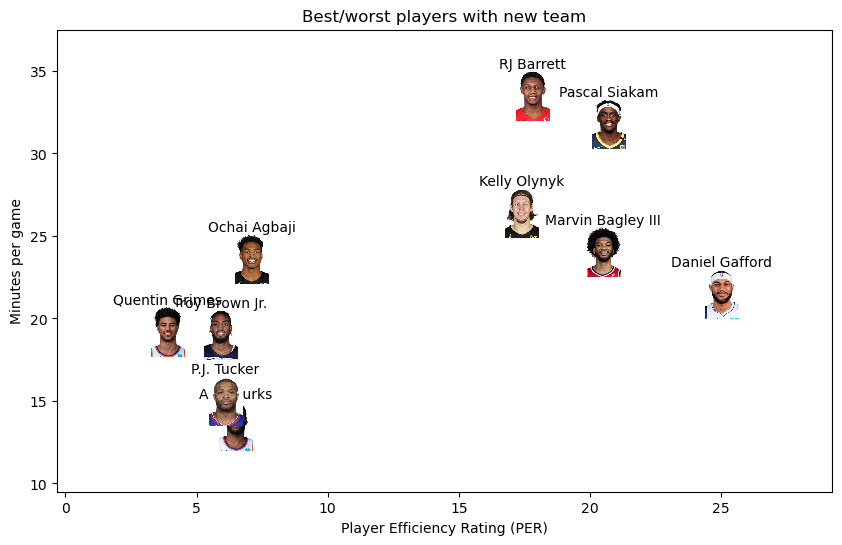

In [7]:
# Scatter plot statistic previously sorted by, compared to another
# statistic. Fetch images for players in DataFrame and show them
# as markers. Increase graph limits by 20 % compared to min/max values.

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(both_ends['PER'], both_ends['MPG'])
plt.xlim(calculate_limits(both_ends, 'PER', 0.2))
plt.ylim(calculate_limits(both_ends, 'MPG', 0.2))
plt.xlabel('Player Efficiency Rating (PER)')
plt.ylabel('Minutes per game')
plt.title('Best/worst players with new team')
for i, row in both_ends.iterrows():
    image_marker = get_image_from_url(
        base_url.format(player_dictionary[row['Player']])
    )
    ab = AnnotationBbox(
        image_marker, (row['PER'], row['MPG']), frameon=False
    )
    ax.add_artist(ab)
    ax.annotate(
        row['Player'], (row['PER'], row['MPG']), textcoords="offset points", 
        xytext=(0,20), ha='center'
    )
plt.show()

#Acquiring good new players is not easy
The graph reveals that among the five best-performing players (by **Player Efficiency Rating***), only Pascal Siakam (Indiana Pacers) and Daniel Gafford (Dallas Mavericks) were on playoff teams, with both their new teams reaching at least the Conference Finals. Conversely, two of the five worst-performing players, Quentin Grimes and Troy Brown Jr., came from the same team (Detroit Pistons). Interestingly, two of the worst-performing players (Quentin Grimes and Alec Burks) were [involved in the same trade](https://www.cbssports.com/nba/news/bojan-bogdanovic-trade-grades-knicks-send-quentin-grimes-to-pistons-reunite-with-alec-burks/), which also included other players, but neither team gained an advantage from acquiring these two specific players.

It is also evident that some teams achieved a very good output from players who played a moderate number of minutes, and in some cases, even fewer minutes than some of the worst performers. This demonstrates that even with limited playing time, it is possible for a player to have a positive impact on the team that acquired them, thus representing a successful investment. However, the overall distribution of player performance according to their minutes generally follows a trend line with only a few outliers.

Ultimately, this analysis suggests that trading for a new player does not always lead to the desired team improvements.

[\***Player Efficiency Rating (PER)**](https://www.basketball-reference.com/about/per.html): The PER sums up all a player's positive accomplishments, subtracts the negative accomplishments, and returns a per-minute rating of a player's performance. The league average is set at 15.